# 당뇨병 데이터 회귀 - 파이토치

In [75]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import seaborn as sns

In [76]:
# 데이터 로딩
file_path = "D:/AI_data/diabetes.csv"
df = pd.read_csv(file_path)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [77]:
# 결측치 확인
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [78]:
# 'Outcome' 컬럼 제거
df = df.drop('Outcome', axis=1)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [79]:
# 레이블 확인
df['BMI'].value_counts()

BMI
32.0    13
31.6    12
31.2    12
0.0     11
32.4    10
        ..
36.7     1
41.8     1
42.6     1
42.8     1
46.3     1
Name: count, Length: 248, dtype: int64

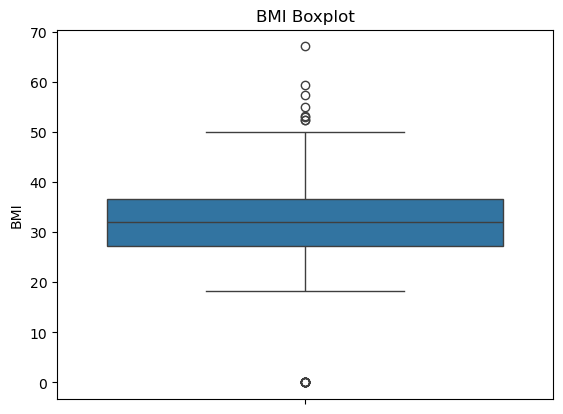

In [80]:
# BMI 시각화
sns.boxplot(df['BMI'])
plt.title("BMI Boxplot")
plt.show()

In [81]:
# 이상치 기준
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 평균 계산 (이상치 제외한 평균)
bmi_mean = df[(df['BMI'] >= lower) & (df['BMI'] <= upper)]['BMI'].mean()

# 이상치 평균으로 대체
df.loc[(df['BMI'] < lower) | (df['BMI'] > upper), 'BMI'] = bmi_mean

In [82]:
# 레이블 확인
df['BMI'].value_counts()

BMI
32.204005    19
32.000000    13
31.600000    12
31.200000    12
33.300000    10
             ..
32.600000     1
43.200000     1
45.500000     1
48.800000     1
46.300000     1
Name: count, Length: 241, dtype: int64

In [83]:
X = df.drop(columns=['BMI'])
y = df['BMI']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [85]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [87]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # 텐서를 2차원으로 reshape
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [88]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## 모델 정의

In [90]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)

## 손실 함수 및 최적화 기법 정의

In [91]:
criterion = nn.MSELoss() # 회귀에서의 loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 학습

In [92]:
# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1077.5529
Epoch 2, Loss: 1012.3009
Epoch 3, Loss: 937.7870
Epoch 4, Loss: 811.1939
Epoch 5, Loss: 636.7963
Epoch 6, Loss: 451.7109
Epoch 7, Loss: 260.5573
Epoch 8, Loss: 142.0875
Epoch 9, Loss: 92.6836
Epoch 10, Loss: 72.3575
Epoch 11, Loss: 66.9537
Epoch 12, Loss: 65.4845
Epoch 13, Loss: 60.4845
Epoch 14, Loss: 57.6947
Epoch 15, Loss: 56.3537
Epoch 16, Loss: 53.7190
Epoch 17, Loss: 51.7691
Epoch 18, Loss: 51.0836
Epoch 19, Loss: 50.2327
Epoch 20, Loss: 46.7153
Epoch 21, Loss: 47.2072
Epoch 22, Loss: 45.8641
Epoch 23, Loss: 44.3226
Epoch 24, Loss: 44.1028
Epoch 25, Loss: 46.2776
Epoch 26, Loss: 41.1192
Epoch 27, Loss: 39.9797
Epoch 28, Loss: 38.8044
Epoch 29, Loss: 39.0630
Epoch 30, Loss: 38.1711
Epoch 31, Loss: 39.3564
Epoch 32, Loss: 36.6462
Epoch 33, Loss: 35.7553
Epoch 34, Loss: 36.6536
Epoch 35, Loss: 34.8543
Epoch 36, Loss: 36.2743
Epoch 37, Loss: 33.9888
Epoch 38, Loss: 34.4735
Epoch 39, Loss: 32.9698
Epoch 40, Loss: 32.8599
Epoch 41, Loss: 32.0845
Epoch 42, Loss:

## 모델 평가

In [93]:
# 평가
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
rmse = mean_squared_error(actuals, preds, squared=False) # mse의 제곱근

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}" )

Test MSE: 31.2180
Test RMSE: 5.5873


C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
